In [1]:
import xgboost as xgb
import pandas as pd
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import geoplot as gplt
import geoplot.crs as gcrs
from sklearn.model_selection import train_test_split
import contextily as cx

In [2]:
data = pd.read_csv('../data/us_life_expectancy.csv')

In [3]:
data

,cartodb_id,countyfp,statefp,statename,countyname,countyfips,tractname,ratio,statemhir,tractmhir,...,BlackorA,AmericanI,Asianalon,NativeHaw,TwoorMor,Hispanico,Whitealon,county,lon,lat
0,80,57,12,Florida,"Hillsborough County, Florida",12057,"Census Tract 108.14, Hillsborough County, Florida",0.575,47212,27143,...,17.4,0.5,3.9,0.1,2.5,26.0,52.3,County,-82.430705,27.873952
1,398,213,48,Texas,"Henderson County, Texas",48213,"Census Tract 9509.01, Henderson County, Texas",0.752,52576,39558,...,6.6,0.8,0.6,0.1,1.6,11.8,79.4,County,-95.853592,32.211895
2,409,409,48,Texas,"San Patricio County, Texas",48409,"Census Tract 102.01, San Patricio County, Texas",0.708,52576,37231,...,2.1,0.9,1.1,0.1,1.4,55.4,40.8,County,-97.244675,27.859829
3,647,5,24,Maryland,"Baltimore County, Maryland",24005,"Census Tract 4209, Baltimore County, Maryland",0.485,74149,35996,...,27.5,0.4,5.7,0.1,2.3,4.8,60.5,County,-76.640195,39.463417
4,712,31,13,Georgia,"Bulloch County, Georgia",13031,"Census Tract 1104.03, Bulloch County, Georgia",0.367,49342,18103,...,28.9,0.4,1.6,0.1,1.6,3.6,64.6,County,-81.743179,32.396803
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3979,4637,101,54,West Virginia,"Webster County, West Virginia",54101,"Census Tract 9701, Webster County, West Virginia",0.683,41576,28416,...,0.4,0.1,0.3,0.0,1.1,0.4,97.7,County,-80.421865,38.494706
3980,4638,103,55,Wisconsin,"Richland County, Wisconsin",55103,"Census Tract 9702, Richland County, Wisconsin",1.033,52738,54477,...,0.6,0.4,0.6,0.0,0.9,2.2,95.4,County,-90.429483,43.375636
3981,4639,21,8,Colorado,"Conejos County, Colorado",8021,"Census Tract 9748, Conejos County, Colorado",0.538,59448,31957,...,0.6,3.5,0.7,0.2,2.2,53.9,43.6,County,-106.191603,37.200716
3982,4640,47,16,Idaho,"Gooding County, Idaho",16047,"Census Tract 9602, Gooding County, Idaho",0.893,47334,42285,...,0.5,1.8,0.8,0.2,1.8,28.8,68.5,County,-114.811564,42.970922


In [4]:
data = data.dropna(subset=['ratio', 'Diversity', 'Asianalon', 'NativeHaw', 'TwoorMor', 'Hispanico', 'Whitealon'])

In [5]:
female_le_q2 = data['le_racea_4']

In [6]:
features = data[['ratio', 'Diversity', 'Asianalon', 'NativeHaw', 'TwoorMor', 'Hispanico', 'Whitealon']]

In [7]:
loc = data[['lon', 'lat']]

In [8]:
X_train, X_temp, y_train, y_temp, loc_train, loc_temp = train_test_split(features, female_le_q2, loc, train_size=0.8, random_state=42)

In [9]:
X_calib, X_test, y_calib, y_test, loc_calib, loc_test = train_test_split(X_temp, y_temp, loc_temp, train_size=0.5, random_state=42)

In [10]:
model = xgb.XGBRegressor(n_estimators=300, max_depth=2, min_child_weight=1, colsample_bytree=0.8)

In [11]:
model.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.8, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=2, max_leaves=None,
             min_child_weight=1, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=300, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [12]:
model.score(X_test, y_test)

0.46910049898555595

In [13]:
from GeoConformal import GWQRBasedGeoConformalSpatialRegression

In [14]:
geocp_spatial = GWQRBasedGeoConformalSpatialRegression(predict_f=model.predict, nonconformity_score_f=None, miscoverage_level=0.1, alpha=4, coord_calib=loc_calib.values, coord_test=loc_test.values, x_calib=X_calib, y_calib=y_calib, x_test=X_test, y_test=y_test)

In [15]:
results = geocp_spatial.analyze()

100%|██████████| 399/399 [04:15<00:00,  1.56it/s]


In [16]:
results.coverage_probability

0.87468671679198

In [17]:
results.geo_uncertainty.mean() / 2

34.07777287281169

In [18]:
geo_results = results.to_gpd()

In [19]:
geo_results

,geo_uncertainty,pred,upper_bound,lower_bound,k,beta,alpha,x,y,geometry
0,20.171322,75.616096,98.180722,78.009400,5.0,0.085106,0.002525,-68.981815,44.174017,POINT (-68.98182 44.17402)
1,105.809094,79.797302,113.023830,7.214737,109.0,0.076457,99.999948,-73.389046,41.067178,POINT (-73.38905 41.06718)
2,38.916264,75.482780,86.329169,47.412905,281.0,0.041708,99.999948,-76.992157,38.507296,POINT (-76.99216 38.50730)
3,11.459563,71.472679,86.957143,75.497580,51.0,0.023641,99.999948,-90.440817,29.256239,POINT (-90.44082 29.25624)
4,47.444647,26.479744,28.772857,-18.671791,92.0,0.041959,99.999948,-98.717409,38.030990,POINT (-98.71741 38.03099)
...,...,...,...,...,...,...,...,...,...,...
394,15.644789,61.821568,77.746420,62.101631,114.0,0.030601,99.999948,-123.979843,46.263047,POINT (-123.97984 46.26305)
395,59.901711,4.166822,29.727179,-30.174532,224.0,0.033378,99.999948,-97.859391,28.905719,POINT (-97.85939 28.90572)
396,93.955072,21.444069,65.483968,-28.471104,141.0,0.031187,99.999948,-99.819567,40.869951,POINT (-99.81957 40.86995)
397,91.742346,58.288246,104.411144,12.668798,377.0,0.041592,99.999948,-84.543416,35.673153,POINT (-84.54342 35.67315)


<GeoAxes: >

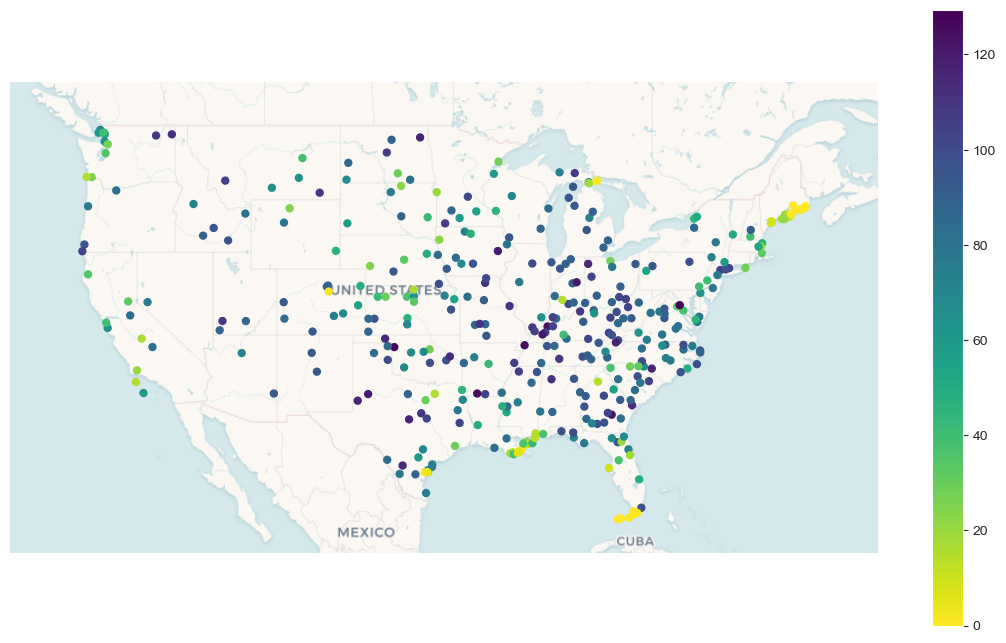

In [20]:
utm = gcrs.WebMercator()

ax = gplt.webmap(geo_results, projection=utm, figsize=(14, 8), provider=cx.providers.CartoDB.Voyager)

gplt.pointplot(geo_results, hue='geo_uncertainty', cmap='viridis_r', legend=True, ax=ax)

<GeoAxes: >

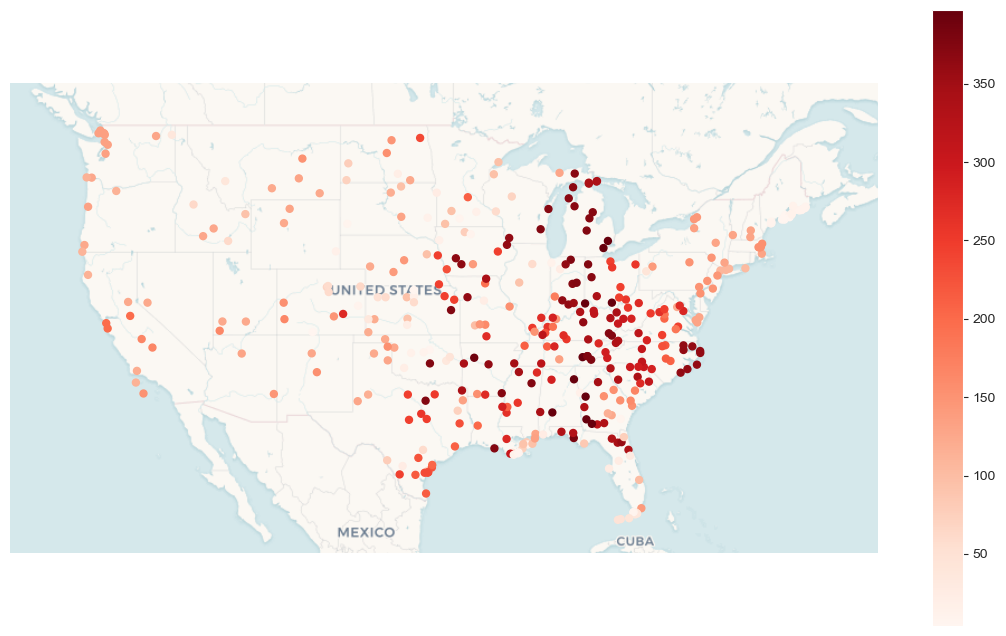

In [21]:
utm = gcrs.WebMercator()

ax = gplt.webmap(geo_results, projection=utm, figsize=(14, 8), provider=cx.providers.CartoDB.Voyager)

gplt.pointplot(geo_results, hue='k', cmap='Reds', legend=True, ax=ax)

In [22]:
from GeoConformal import GeoConformalSpatialPrediction

In [23]:
geocp_spatial_std = GeoConformalSpatialPrediction(predict_f=model.predict, nonconformity_score_f=None, miscoverage_level=0.1, bandwidth=3, coord_calib=loc_calib.values, coord_test=loc_test.values, X_calib=X_calib, y_calib=y_calib, X_test=X_test, y_test=y_test)

In [24]:
results_std = geocp_spatial_std.analyze()

In [25]:
results_std.coverage_probability

0.9223057644110275

In [26]:
results_std.geo_uncertainty.mean()

46.72197975955055

In [27]:
from GeoConformal import LSCP

In [28]:
lscp = LSCP(predict_f=model.predict, nonconformity_score_f=None, miscoverage_level=0.1, coord_calib=loc_calib.values, coord_test=loc_test.values, x_calib=X_calib, y_calib=y_calib, x_test=X_test, y_test=y_test)

In [29]:
results_lscp = lscp.analyze()

100%|██████████| 399/399 [00:42<00:00,  9.40it/s]


In [30]:
results_lscp.coverage_probability

0.87468671679198

In [31]:
results_lscp.geo_uncertainty.mean() / 2

41.93613841157473